In [0]:
import os
import numpy as np
import pandas as pd
import zipfile
import cv2
import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow.keras as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [0]:
from tensorflow.keras.callbacks import TensorBoard
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
# data_dir = "/content/drive/My Drive/dl_dataset/kaggle/"

In [0]:
# os.environ['KAGGLE_CONFIG_DIR'] = data_dir

In [0]:
# !kaggle datasets download -d nikitarom/planets-dataset

In [0]:
# %cd /content/drive/My Drive/dl_dataset/kaggle/

In [0]:
# !unzip planets-dataset.zip

In [0]:
# df_train = pd.read_csv('../../planet/train_classes.csv')

In [0]:
# df_train.tail(4)

In [0]:
split_tags = lambda l: [item for sublist in l for item in sublist]
labels = list(set(split_tags([l.split(' ') for l in df_train['tags'].values])))

In [0]:
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

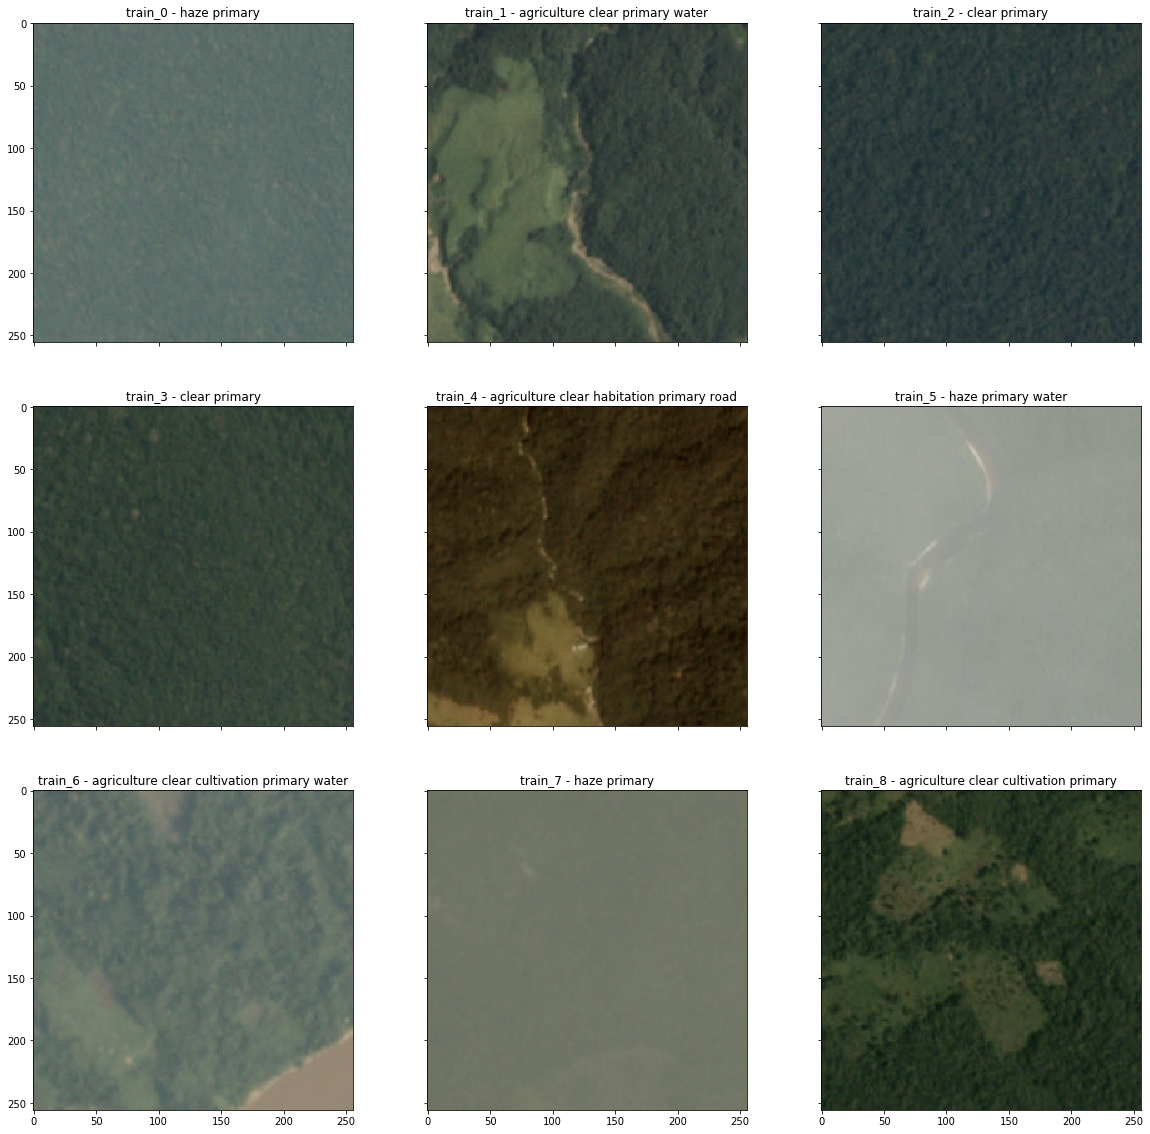

In [0]:
# Reference: https://www.kaggle.com/anokas/data-exploration-analysis
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in df_train[:9].values:
    img = cv2.imread('../../planet/' + 'train-jpg/{}.jpg'.format(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    i += 1
    
plt.show()

# Training
Images are read through imread  
cv2.resize configures in the reqd format

In [0]:
x_train = []
x_test = []
y_train = []

for f, tags in tqdm(df_train.values, miniters=1000):
    imgage = cv2.imread('../../planet/' + 'train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(imgage, (32, 32)))
    y_train.append(targets)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40479/40479 [00:45<00:00, 889.06it/s]


In [0]:
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

In [0]:
test_train_split = 30000
x_train, x_valid, y_train, y_valid = x_train[:test_train_split], x_train[test_train_split:], y_train[:test_train_split], y_train[test_train_split:]

In [0]:
model = Sequential()

In [0]:
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3))) # input size is what we reized all images to
# Conv2D

In [0]:
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3))) # input size is what we reized all images to
model.add(Conv2D(128, (6, 6), activation='relu'))

In [0]:
model.add(MaxPooling2D(pool_size=(4, 4)))

In [0]:
#Drpout
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(17, activation='sigmoid'))

In [0]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = k.callbacks.TensorBoard(logdir, histogram_freq=1)

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [0]:
train_history = model.fit(x_train, y_train, batch_size=128, epochs=4, verbose=1, validation_data=(x_valid, y_valid), callbacks=[tensorboard])

Train on 30000 samples, validate on 10479 samples
Epoch 1/4
30000/30000 [==============================] - 9s 288us/sample - loss: 0.2452 - accuracy: 0.9883 - val_loss: 0.1984 - val_accuracy: 0.9200
Epoch 2/4
30000/30000 [==============================] - 6s 197us/sample - loss: 0.2032 - accuracy: 0.9245 - val_loss: 0.1906 - val_accuracy: 0.9266
Epoch 3/4
30000/30000 [==============================] - 6s 198us/sample - loss: 0.1829 - accuracy: 0.9257 - val_loss: 0.1749 - val_accuracy: 0.9296
Epoch 4/4
30000/30000 [==============================] - 6s 198us/sample - loss: 0.1796 - accuracy: 0.9294 - val_loss: 0.1702 - val_accuracy: 0.9323


In [0]:
def show_train_history(train_history, train, validation, title):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title(title)
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()

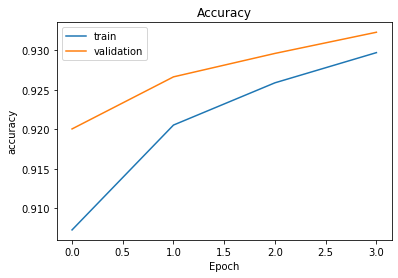

In [0]:
show_train_history(train_history, 'accuracy', 'val_accuracy', 'Accuracy')

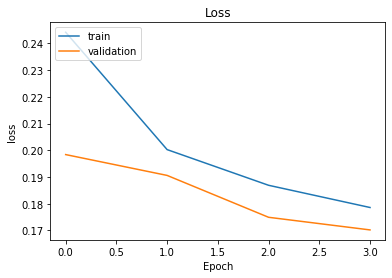

In [0]:
show_train_history(train_history, 'loss', 'val_loss', 'Loss')

Tensorboard

In [0]:
%tensorboard --logdir my_logs